# Cross-shore spectra
Compare spectra from 3-ADCP array (C1, C3, C6) across the Asilomar 2022 small-scale array rock.

In [9]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from tqdm.notebook import tqdm
import cmocean
import matplotlib.pyplot as plt
from matplotlib import colors
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws

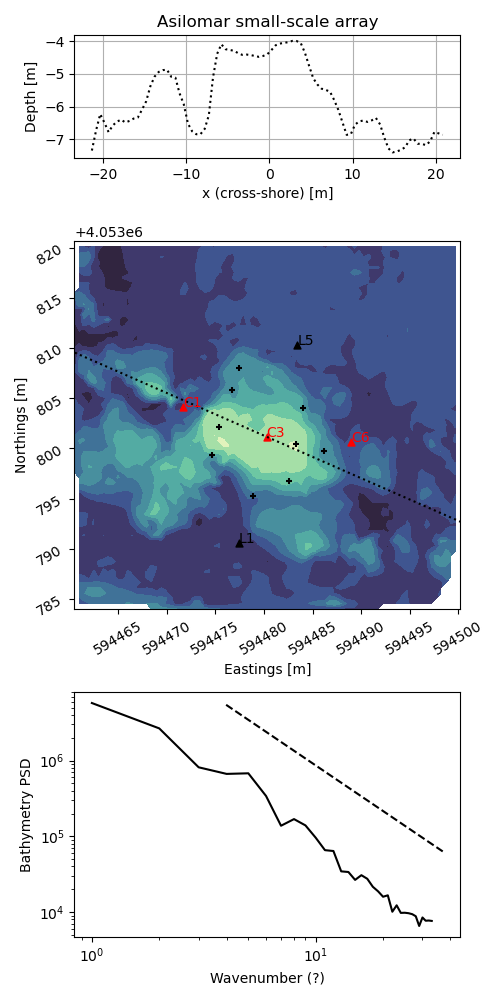

xs,xe=594434.2362573274,594526.2867426727 - ys,ye+4053820.7049564244,4053781.6318435753


In [2]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
sers = ['103088', '103094', '103110',]
mids = ['C1', 'C3', 'C6'] # Mooring IDs

fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(5,10), nrows=3, gridspec_kw={'height_ratios': [1, 3, 2]},
                         constrained_layout=True)
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
            cmap=cmocean.cm.deep_r)
# Mooring locations
s = 25 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), 'C1', color='r')
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), 'C3', color='r')
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='r', s=s)
axes[1].text(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), 'C6', color='r')
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), 'L1', color='k')
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].text(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), 'L5', color='k')
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='k', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='k', s=s)
# Axis params
axes[1].set_xlim([dsb.eastings.min(), dsb.eastings.max()])
axes[1].set_ylim([dsb.northings.min(), dsb.northings.max()])
axes[1].set_xlabel('Eastings [m]')
axes[1].set_ylabel('Northings [m]')
axes[1].tick_params(labelrotation=30)

# Mark cross-shore transect
rot_ang = 293
ang_math = 270 - rot_ang
x = dsb.eastings.values
y = dsb.northings.values
L = 50 # Length
x0 = dsb.C3_utm[0].item()
y0 = dsb.C3_utm[1].item()
x_end = x0 + L * np.cos(np.deg2rad(ang_math)) # Far-field end point
y_end = y0 + L * np.sin(np.deg2rad(ang_math))
x_start = x0 - L * np.cos(np.deg2rad(ang_math)) # Near-field start point
y_start = y0 - L * np.sin(np.deg2rad(ang_math))
xt = xr.DataArray(np.linspace(x_start, x_end, 200), dims='h') # Full line x points
yt = xr.DataArray(np.linspace(y_start, y_end, 200), dims='h') # Full line y points
# Take transect along xt, yt
transect = dsb.z_utm.interp(eastings=xt, northings=yt, method='linear')
# Make rotated spatial axes for transect
# x_dist = transect.eastings.values +  np.abs(np.min(transect.eastings.values))
# y_dist = transect.northings.values +  np.abs(np.min(transect.northings.values))
x_dist = transect.eastings.values - x0
y_dist = transect.northings.values - y0
dist_axis = np.sqrt(x_dist**2 + y_dist**2)
dist_axis[np.where(np.logical_or(x_dist<0, y_dist>0))] *= -1

# Plot cross-shore transect line
axes[1].plot(transect.eastings, transect.northings, color='k', linestyle=':')

# Plot transect on top row
axes[0].plot(dist_axis, transect.values, color='k', linestyle=':')
axes[0].set_title('Asilomar small-scale array')
axes[0].set_xlabel('x (cross-shore) [m]')
axes[0].set_ylabel('Depth [m]')
axes[0].grid()

# Compute spectrum of bathymetry and plot it on the bottom row
# Array must be square, so crop edges from bathy array in x direction
# Follow example at 
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
bathy_square = dsb.isel(eastings=slice(7,-7), northings=slice(2,-2)).copy()
npix = bathy_square.z_utm.shape[0]
# Take FFT of bathy
image = bathy_square.z_utm.values
fourier_image = np.fft.fftn(image)
# Get variance
fourier_amplitudes = np.abs(fourier_image)**2
# Construct wavenumber array
dx = dsb.eastings.values[1] - dsb.eastings.values[0]
kfreq = np.fft.fftfreq(npix) * npix
# Create 2D wavenumber grid
kfreq2D = np.meshgrid(kfreq, kfreq)
# We are not really interested in the actual wave vectors, but rather in their norm
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
# Flatten arrays
knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()
# Bin amplitudes in wavenumber space
kbins = np.arange(0.5, npix//2+1, 1.)
# Note that the maximum wave number will equal half the pixel size of the image. 
# This is because half of the Fourier frequencies can be mapped back to negative 
# wavenumbers that have the same norm as their positive counterpart.
kvals = 0.5 * (kbins[1:] + kbins[:-1])
# Compute the average Fourier amplitude (squared) in each bin
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
# To get the total power, we need to multiply with the volume in each bin
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

# Plot bathymetry power spectrum on bottom row
axes[2].loglog(kvals, Abins, color='k')
# Plot k^-2 line
ksmin, ksmax = axes[2].get_xlim()
ks = np.linspace(ksmin, ksmax)
axes[2].loglog(ks[4:-3], 15*Abins.max() * ks[4:-3]**(-2), color='k', linestyle='--')
axes[2].set_xlabel('Wavenumber (?)')
axes[2].set_ylabel('Bathymetry PSD')

plt.tight_layout()
plt.show()


print('xs,xe={},{} - ys,ye+{},{}'.format(x_start, x_end, y_start, y_end))

## Concatenate daily spectra
Also plot time series of wave conditions during the experiment.

Reading 103088-C1 netcdf files ...


  0%|          | 0/27 [00:00<?, ?it/s]

Reading 103094-C3 netcdf files ...


  0%|          | 0/26 [00:00<?, ?it/s]

Reading 103110-C6 netcdf files ...


  0%|          | 0/28 [00:00<?, ?it/s]

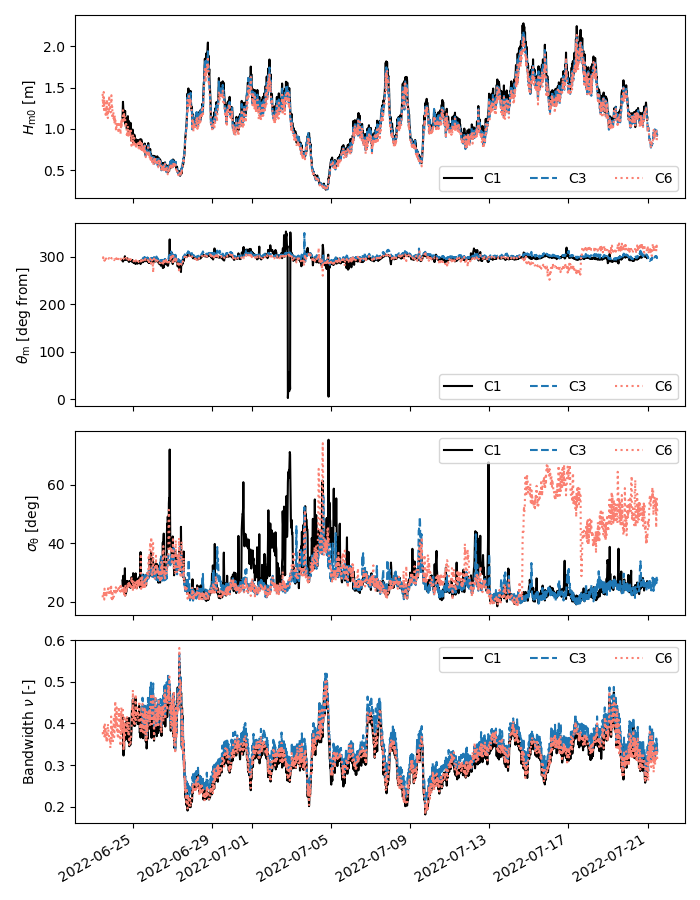

In [4]:
# Use all available serial numbers
spec_key = 'ETAl' # Spectrum heave product
# Save mean datasets in dict
dsds = {} # Spectrum datasets
for ser, mid in zip(sers, mids):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's spectrum directories
    specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory
    # List spectrum netcdf files for specified serial number
    fns_nc_spec = sorted(glob.glob(os.path.join(specdir, '*{}_*.nc'.format(spec_key))))
    dssl = [] # Empty list for concatenating spectrum datasets
    # Iterate over and read files, and append to list for concatenating
    for fns in tqdm(fns_nc_spec):
        # Read spectrum netcdf
        dss = xr.decode_cf(xr.open_dataset(fns, decode_coords='all'))
        dssl.append(dss) # Append daily spectra to list

    # Concatenate datasets into one
    dss = xr.concat(dssl, dim='time')
    dsds[mid] = dss # Save in dict

# Plot time series
fig, axes = plt.subplots(figsize=(7,9), nrows=4, sharex=True, constrained_layout=True)
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Hs on top
    dsds[mid].Hm0.plot(ax=axes[0], color=cls[i], linestyle=lss[i], label=mid)
    axes[0].set_ylabel(r'$H_\mathrm{m0}$ [m]')
    # Mean/peak dir on 2nd row
    dsds[mid].mdir.plot(ax=axes[1], color=cls[i], linestyle=lss[i], label=mid)
    axes[1].set_ylabel(r'$\theta_\mathrm{m}$ [deg from]')
    # Directional spread on 3rd row
    dsds[mid].dspr.plot(ax=axes[2], color=cls[i], linestyle=lss[i], label=mid)
    axes[2].set_ylabel(r'$\sigma_\mathrm{\theta}$ [deg]')
    # Frequency bandwidth on 4th row
    dsds[mid].nu_LH57.plot(ax=axes[3], color=cls[i], linestyle=lss[i], label=mid)
    axes[3].set_ylabel(r'Bandwidth $\nu$ [-]')

for ax in axes:
    ax.set_xlabel(None)
    ax.legend(ncol=3)

plt.tight_layout()
plt.show()


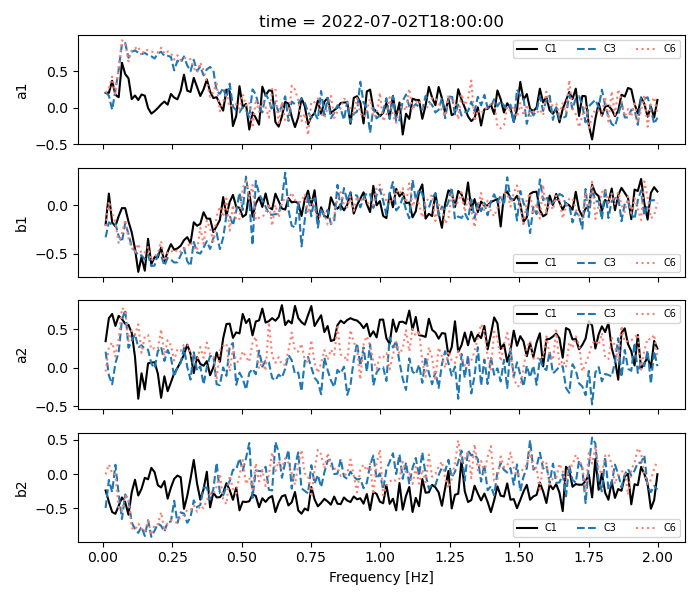

In [41]:
# Plot comparison of a1, b1, a2, b2 moments for 2022-07-02-19:00
fig, axes = plt.subplots(figsize=(7,6), nrows=4, sharex=True)
t0 = pd.Timestamp('2022-07-02 18:00:00')
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i,mid in enumerate(mids):
    # Plot a1 on first row etc
    dsds[mid].sel(time=t0).a1.plot(ax=axes[0], label=mid, color=cls[i], linestyle=lss[i])
    axes[0].set_ylabel('a1')
    axes[0].set_xlabel(None)
    dsds[mid].sel(time=t0).b1.plot(ax=axes[1], label=mid, color=cls[i], linestyle=lss[i])
    axes[1].set_ylabel('b1')
    axes[1].set_xlabel(None)
    axes[1].set_title(None)
    dsds[mid].sel(time=t0).a2.plot(ax=axes[2], label=mid, color=cls[i], linestyle=lss[i])
    axes[2].set_ylabel('a2')
    axes[2].set_xlabel(None)
    axes[2].set_title(None)
    dsds[mid].sel(time=t0).b2.plot(ax=axes[3], label=mid, color=cls[i], linestyle=lss[i])
    axes[3].set_ylabel('b2')
    axes[3].set_title(None)
axes[-1].set_xlabel('Frequency [Hz]')

for ax in axes:
    ax.legend(ncol=3, fontsize=7)

plt.tight_layout()
plt.show()



IndexError: Replacement index 1 out of range for positional args tuple

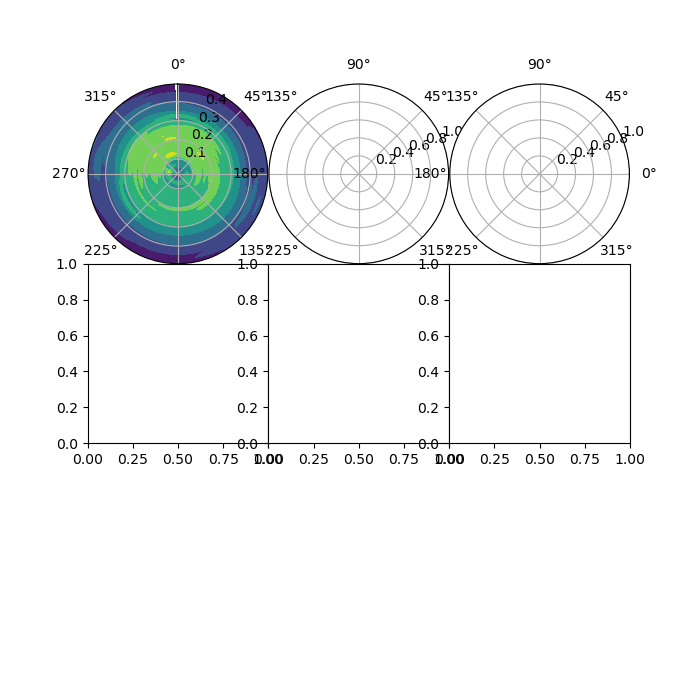

In [28]:
# Plot directional spectra vs directional distr. for given time
fig = plt.figure(figsize=(7,7),)
fig.subplots_adjust(hspace=0, wspace=0)
ap = [] # Polar axes
ap.append(fig.add_subplot(331, projection='polar'))
ap.append(fig.add_subplot(332, projection='polar'))
ap.append(fig.add_subplot(333, projection='polar'))
an = [] # Normal axes
an.append(plt.subplot(334))
an.append(plt.subplot(335, sharey=an[0]))
an.append(plt.subplot(336, sharey=an[0]))
t0 = pd.Timestamp('2022-07-02 18:00:00')
lss = ['-', '--', ':'] # Linestyles
cls = ['k', 'C0', 'salmon']
for i, mid in enumerate(mids):
    # Plot directional spectrum in polar coordinates
    cs1 = ap[i].contourf(np.deg2rad(dsds[mid].Efth.direction.values),
        dsds[mid].Efth.sel(time=t0, freq=slice(0.01, 0.5)).freq.values,
        dsds[mid].Efth.sel(time=t0, freq=slice(0.01, 0.5)).values,
        norm=colors.LogNorm(),)
    # Fix directions
    ap[i].set_theta_zero_location("N")
    ap[i].set_theta_direction(-1)
    ap[i].set_title('{}'.format(mid))
    # Plot directional distribution below
    eth = dsds[mid].Efth.sel(time=t0).integrate(coord='freq')
    an[i].plot(dsds[mid].direction.values, eth, color='k')
    an[i].set_title('{} dir. distr.'.format(mid))
    an[i].set_xlabel('direction [deg]')
    an[i].set_xticks([0, 180, 360])

# plt.subplots_adjust(wspace=0., hspace=0.)
plt.suptitle(t0)
plt.tight_layout()
plt.show()